In [1]:
import matplotlib
import jsonlines
import sys
from itertools import product
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

sys.path.append('../src/')
from utils import iterate_bru_args
from utils import bru_args_to_tuple
from utils import MatchingType

In [2]:
def load_steps(filename: Path, prefix: str) -> np.array:
    with jsonlines.open(filename) as dataset:
        label = f"avg_{prefix}_step"
        xs = [data[label] for data in dataset if data[label] is not None]
    return np.array(xs)

In [3]:
steps = {}
for matching_type in (e.value for e in MatchingType):
    steps_matching_type = steps.setdefault(matching_type, {})
    bru_tuples = map(bru_args_to_tuple, iterate_bru_args())
    for construction, scheduler, memo_scheme in bru_tuples:
        basename = '-'.join([
            'all', matching_type, construction, scheduler, memo_scheme]) + '.jsonl'
        path = Path(f'../data/step') / basename
        steps_construction = steps_matching_type.setdefault(construction, {})
        steps_scheduler = steps_construction.setdefault(scheduler, {})
        steps_memo_scheme = steps_scheduler.setdefault(memo_scheme, {})
        for input_type in ['positive', 'negative']:
            xs = load_steps(path, input_type)
            steps_memo_scheme.setdefault(input_type, xs)

In [4]:
xs = steps['full']['thompson']['lockstep']['none']['positive']
ys = steps['full']['flat']['lockstep']['none']['positive']

In [5]:
# Range excluding outliers
total = xs + ys
quartile_1 = np.quantile(total, 0.25)
quartile_3 = np.quantile(total, 0.75)
iqr = quartile_3 - quartile_1
maximum = np.max(total, where=xs <= quartile_3 + 1.5 * iqr, initial=-np.inf)
minimum = np.min(total, where=xs >= quartile_1 - 1.5 * iqr, initial=np.inf)

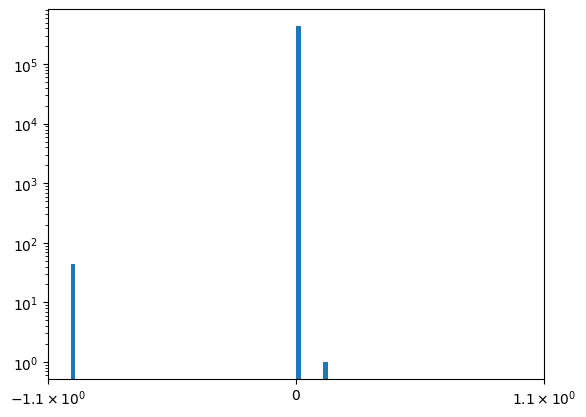

In [6]:
# Atan Histogram
normalized_theta = (np.arctan2(xs, ys) - np.pi/4) / (np.pi/4)
plt.hist(normalized_theta, bins=100, range=[-1, 1])
plt.xscale('symlog')
plt.yscale('log')
plt.show()

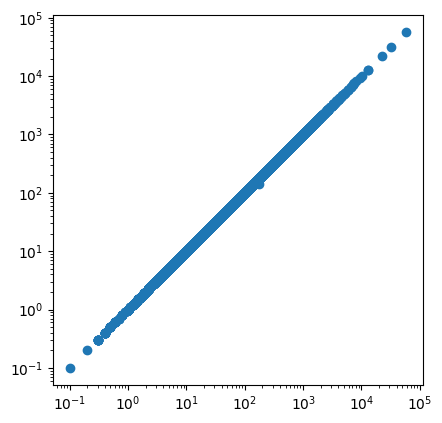

In [7]:
# Scatter plot
plt.scatter(xs, ys)
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.show()

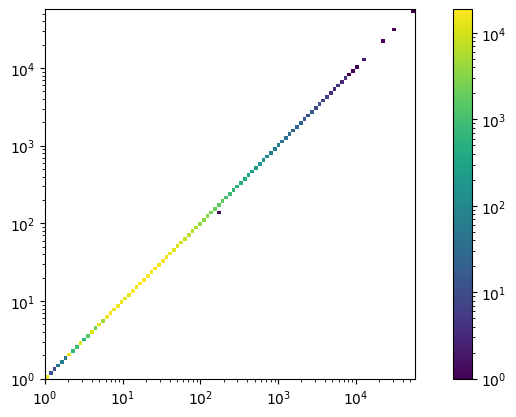

In [8]:
# Histogram 2D
x_space = np.geomspace(1, max(xs), 100)
y_space = np.geomspace(1, max(ys), 100)
h = plt.hist2d(xs, ys, bins=(x_space, y_space), norm = 'log')
plt.colorbar(h[3])
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.show()

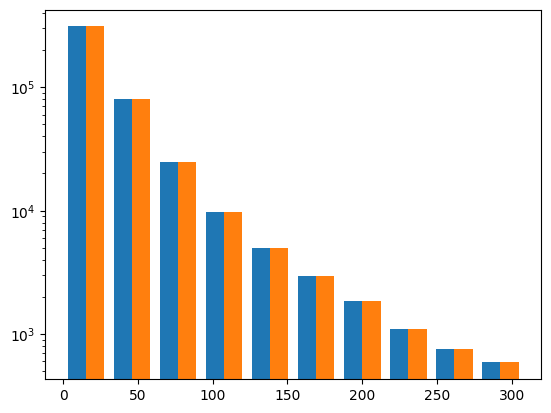

In [9]:
# Histogram (excluding outliers)
plt.hist([xs, ys], range=(minimum, maximum), log=True, bins=10)
plt.show()

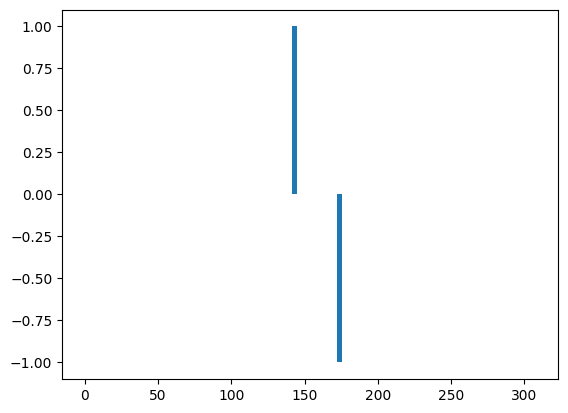

In [10]:
# Difference of histogram (excluding outliers)
plt1, bin1, _ = plt.hist(xs, range=(minimum, maximum), log=True, bins=100)
plt2, bin2, _ = plt.hist(ys, range=(minimum, maximum), log=True, bins=100)
plt.clf()
plt.bar(bin1[:-1], width = np.diff(bin1), height=plt2 - plt1, align='edge')
plt.show()